# 第4章 画像処理と畳み込みニューラルネット - 2

## 4.4 CNN回帰モデルによる画像の高解像度化
* CNNは回帰問題にも利用できる
  * 画像を別の画像に変換するという応用が可能
  * CNNを利用した顔画像の高解像度化

### 4.4.1 データ準備
* Labeled Faces in th Wild（LFW, 代表的な顔画像データセット）
  * LFW deep funneled images（顔が垂直になるようにアラインされたデータセット）
  * http://vis-www.cs.umass.edu/lfw/
    * All images aligned with deep funnelingというリンクからDL
    * 直リンク: http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
* 128x128の画像(y)と、それを32x32に縮小した画像(x)を用意し、xをCNNで拡大した結果とyとの誤差を最小化

In [1]:
%matplotlib inline
import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
# loggerを使う
from logging import getLogger, StreamHandler, Formatter

# create logger
logger = getLogger(__name__)
log_fmt = Formatter("%(asctime)s %(name)s %(lineno)s [%(levelname)s][%(funcName)s] %(message)s")

# ログレベル設定
#log_level = "INFO"
log_level = "DEBUG"
logger.setLevel(log_level)

# handlerの生成
handler = StreamHandler()
handler.setLevel(log_level)
handler.setFormatter(log_fmt)
logger.addHandler(handler)

In [3]:
# gpuを使えるときはgpuを使う
device = "cuda" if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
class DownSizedPairImageFolder(ImageFolder):
    def __init__(self, root, transform=None, large_size=128, small_size=32, **kwargs):
        super().__init__(root, transform=transform, **kwargs)
        self.large_resizer = transforms.Resize(large_size)
        self.small_resizer = transforms.Resize(small_size)
    
    def __getitem__(self, index):
        path, _ = self.imgs[index]
        img = self.loader(path)
        
        # 読み取った画像を128x128xと32x32にリサイズする
        # 試用する画像が正方形でない場合で、正方形にしたい場合はリサイズのあとにCenterCropするとよい
        large_img = self.large_resizer(img)
        small_img = self.small_resizer(img)
        
        # その他の変換を適用する
        if self.transform is not None:
            large_img = self.transform(large_img)
            small_img = self.transform(small_img)
        
        # 32pixelの画像と128pixelの画像を返す
        return small_img, large_img

#### 補足
* DataLoaderの作成時にnum_workersを指定すると並列処理できる
* が、windowsだと学習時にBrokenPipiErrorを吐いてしまうもよう
  * 参考1: https://github.com/pytorch/pytorch/issues/2341
  * 参考2: https://qiita.com/fmfm_mdk/items/726aeacf8f6efe10009e

In [5]:
# 画像データ読み込み
train_data = DownSizedPairImageFolder("./data/LFW/lfw-deepfunneled/train/", transform=transforms.ToTensor())
test_data = DownSizedPairImageFolder("./data/LFW/lfw-deepfunneled/test/", transform=transforms.ToTensor())

# DataLoaderの作成
batch_size = 32

# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8)
# test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=8)

# windowsではnum_workerを指定すると死ぬのでとりあえず使わない
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

### 4.4.2 モデル作成
* Conv2dとConvTransposed2dを積み重ねたCNNを作る
  * Conv2dでstride（カーネルをずらすときのpixel数）を2にするとプーリング層の役割も兼ねる？
    * MaxPool2dがなくても画像のサイズが1/2になる
  * ConvTrnasposed2d: Transposed Convolutionと呼ばれる畳み込み演算
    * 畳み込みカーネルを行列に展開したときに、通常の畳み込みの行列の転置になっている
    * stride=2にすると、画像サイズがおよし2倍になる
    * 入力と出力の画像サイズが通常の畳み込みと逆になる
    * この性質を利用して画像を拡大することができる
    * 計算の都合上、微妙にサイズが2倍や1/2からずれるので、paddingで調整する
      * このあたりはダミーのデータを入れて出力サイズを確認しながら試行錯誤する

In [6]:
net = nn.Sequential(
    nn.Conv2d(3, 256, 4, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    
    nn.Conv2d(256, 512, 4, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(512),
    
    nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    
    nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    
    nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    
    nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1)
)

In [7]:
import math
def psnr(mse, max_v=1.0):
    """
    画像や音声などの信号の復元問題でよく用いられる指標
    """
    return 10 * math.log10(max_v / mse)

In [8]:
# 評価のヘルパ－関数
def eval_net(net, data_loader, device):
    # 初期化
    net.to(device).eval()
    ys = []
    ypreds = []
    
    for x, y in data_loader:
        # gpuを使う場合の処理
        x = x.to(device)
        y = y.to(device)
        
        y_pred = net(x)
        ys.append(y)
        ypreds.append(y_pred)
    
    # ミニバッチごとの予測結果などを1つにまとめる
    # logger.debug(f"last y: {y}")
    # logger.debug(f"last y_pred: {y_pred}")
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)
    
    # 予測精度を計算
    score = nn.functional.mse_loss(ypreds, ys).item()
    
    return score

In [9]:
# 学習のヘルパー関数
# 回帰問題なので、損失関数にはMSEを使う
# nn.MSELoss以外に、nn.functional.mse_lossでもよい
def train_net(net, train_loader, test_loader, device, optimizer_cls=optim.Adam
              , loss_fn=nn.MSELoss(), n_iter=10):
    # 初期化
    net.to(device).train()
    train_losses = []
    train_acc = []
    val_acc = []
    optimizer = optimizer_cls(net.parameters())
    
    for epoch in tqdm(range(n_iter)):
        # 初期化
        running_loss = 0.0
        n = 0
        score = 0
        
        for i, (x, y) in enumerate(train_loader):
            # gpuを使う場合の処理
            x = x.to(device)
            y = y.to(device)
            
            y_pred = net(x)
            loss = loss_fn(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            n += len(x)
            y_pred = net(x)
            score += nn.functional.mse_loss(y_pred, y).item()
            
        train_losses.append(running_loss / len(train_loader))
        
        # 学習データの予測精度
        train_acc.append(score / n)
        
        # testデータの予測精度
        val_acc.append(eval_net(net, test_loader, device))
        
        # このepochでの結果を表示
        logger.debug(f"epoch: {epoch}")
        logger.debug(f"train_losses: {train_losses[-1]}")
        logger.debug(f"psnr loss: {psnr(train_losses[-1])}")
        logger.debug(f"psnr val_acc: {psnr(val_acc[-1])}") # これ合ってる？
        
    return train_losses, train_acc, val_acc

In [13]:
# 実行（cpuだと時間がかかる）
train_losses, train_acc, val_acc = train_net(net, train_loader, test_loader, device, n_iter=10)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]2020-05-06 19:51:00,490 __main__ 44 [DEBUG][train_net] epoch: 0
2020-05-06 19:51:00,492 __main__ 45 [DEBUG][train_net] train_losses: 0.0587630329976965
2020-05-06 19:51:00,492 __main__ 46 [DEBUG][train_net] psnr loss: 12.308957966093296
2020-05-06 19:51:00,493 __main__ 47 [DEBUG][train_net] psnr val_acc: 20.97031147514556
 10%|████████▎                                                                          | 1/10 [00:41<06:16, 41.84s/it]2020-05-06 19:51:41,839 __main__ 44 [DEBUG][train_net] epoch: 1
2020-05-06 19:51:41,840 __main__ 45 [DEBUG][train_net] train_losses: 0.00547222447670395
2020-05-06 19:51:41,840 __main__ 46 [DEBUG][train_net] psnr loss: 22.618360956822634
2020-05-06 19:51:41,841 __main__ 47 [DEBUG][train_net] psnr val_acc: 22.993160600690633
 20%|████████████████▌                                                                  | 2/10 [01:23<05:33, 41.

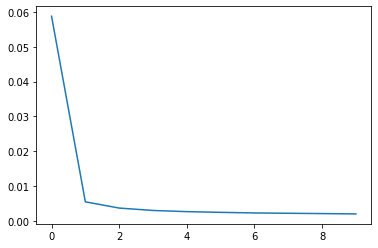

In [14]:
# 確認
plt.plot(train_losses)

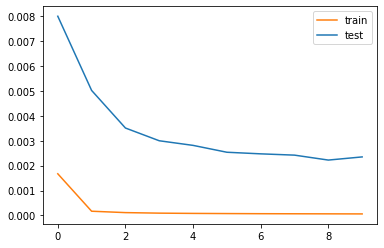

In [15]:
# 確認
plt.plot(train_acc, color="tab:orange", label="train")
plt.plot(val_acc, color="tab:blue", label="test")
plt.legend()

#### 実際に高解像度化した画像を見てみる
* 画像への出力には`torchvision.utils.save_image`が便利
  * Tensorのリストを受け取り、グリッド表示にして画像ファイルとして書き出せる
* 一般的に使用されるBilinear補完も併せて比較する

In [18]:
from torchvision.utils import save_image

# testデータからランダムに4つずつ取り出すDataLoader
random_test_loader = DataLoader(test_data, batch_size=4, shuffle=True)

# DataLoaderをpythonのイテレータに変換し、最初の4つを取り出す
it = iter(random_test_loader)
x, y = next(it)

# Bilinearで拡大
# torch.nn.functional.upsampleはdeplecatedなので、nn.functional.interpolateを使う
# bl_recon = torch.nn.functional.upsample(x, 128, mode="bilinear")
bl_recon = torch.nn.functional.interpolate(x, 128, mode="bilinear")
# CNNで拡大
yp = net(x.to(device)).to(device).cpu()

# torch.catでオリジナル、bilinear、CNNの画像を結合し、save_imageで画像ファイルに書き出し
save_image(torch.cat([y, bl_recon.data, yp.data], 0), "./output/cnn_upscale.jpg", nrow=4)

## 4.5 DCGANによる画像生成
* GAN: Generative Adversarial Network
  * DCGAN: Deep Convolutional GAN

### 4.5.1 GANとは
* 生成モデルG(Generator)と識別モデルD(Discriminator)の2つを用意し、交互に学習を行う
  * G：あるK次元の潜在特徴ベクトルを入力として受け取り、対象と同じ形式のデータを生成するNN
  * D：対象のデータを入力として真偽を識別するNN
* 学習手順の概要
  1. 潜在特徴ベクトルzを乱数により生成し、G(z)によって偽のデータ(fake_data)を生成: fake_data <- G(z)
  1. fake_dataをDで判別: fake_out <- D(fake_data)
  1. 実際のデータのサンプル(real_data)を用意し、Dで判別: real_out <- D(real_data)
  1. fake_outのラベルが正例だとしてクロスエントロピーを計算し、Gのパラメータを更新
  1. real_outのラベルが正例、fake_outのラベルが負例としてクロスエントロピーを計算し、Dのパラメータを更新
  1. 1に戻る
* 4でGが生成したデータがうまくDを騙せたとしてGを更新し、逆に5でDがそれをうまく見破ったとしてDを更新する、というのを交互に繰り返していく

### 4.5.2 データの準備
* Oxford 102: 花のデータセット
  * https://www.robots.ox.ac.uk/~vgg/data/flowers/102/
* 64x64の画像を生成するため、最も短い辺を80にリサイズしてからCenterCropする

In [19]:
img_data = ImageFolder("./data/flowers/oxford102/"
                       , transform=transforms.Compose([
                           transforms.Resize(80),
                           transforms.CenterCrop(64),
                           transforms.ToTensor()
                       ]))

batch_size = 64
img_loader = DataLoader(img_data, batch_size=batch_size, shuffle=True)

### 4.5.3 pytorchによるDCGAN
* 元論文と公式のサンプルプログラムの実装をベースに分かりやすいように著者が改変した実装
  * G: 潜在特徴ベクトルzを100次元とし、zから3x64x64の画像を作る生成モデル
    * 4.4で扱ったTransposed Convolutionを使用
    * Transposed Convolutionによって画像のサイズは以下のように変化する
      ```
      out_size = (in_size - 1) * stride - 2 * padding + kernel_size + output_padding
      ```
  * D: 3x64x64の画像を1次元(1x1x1)のスカラーに変換するネットワーク
    * 元論文では線形層を一切使用しない方法を推奨
    * forwardの最後にあるsqueezeはAx1xBx1のように無駄に1が入っているshapeをAxBにそぎ落とす操作
      * Conv2dの最終的な出力が(batch_size, 1, 1, 1)になるので余分な次元を落とす

In [21]:
# nzとngfはコンストラクタに入れるべきなのでは...？
nz = 100 # zの次元
ngf = 32

class GNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels=nz, out_channels=ngf * 8, kernel_size=4
                               , stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, x):
        out = self.main(x)
        return out

In [22]:
ndf = 32

class DNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False), # 各引数はConvTranspose2dと同様
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)
        )
        
    def forward(self, x):
        out = self.main(x)
        return out.squeeze()

In [ ]:
# 学習関数